In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import deepmatcher as dm
from utils.intermediate_layer_extraction import return_layer_input
from utils.ri_calculator import computeRi
from utils.distance_measures import calculate_nearest_neighbors_onAttributes
import pandas as pd

In [4]:
attributes = ['Song_Name','Artist_Name','Album_Name','Genre','Price','CopyRight','Time','Released']

## Hybrid

### Datasets creation for hybrid

In [5]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state('../../models/itunesamazon_hybrid.pth')

In [6]:
neg_classifier_hybrid,neg_ids = return_layer_input('../../Structured/itunes-amazon'
                                                                         ,'negatives',128,hybrid_model,
                                                                        hybrid_model.classifier,device=-1)

In [7]:
pos_classifier_hybrid,pos_ids = return_layer_input('../../Structured/itunes-amazon/',
                                                                       'positives',128,hybrid_model,
                                                                       hybrid_model.classifier,device=-1)

In [8]:
hybrid_model = hybrid_model.cuda()

### Negative sample analysis

In [9]:
classifier_len_hybrid = len(neg_classifier_hybrid[0][0])
attribute_len_hybrid = int(classifier_len_hybrid/len(attributes))

In [16]:
negatives_ri_hybrid,neg_ri_norms_hybrid = computeRi(hybrid_model.classifier,
                                                    attributes,neg_classifier_hybrid,attribute_len_hybrid,1)

100%|██████████| 128/128 [00:24<00:00,  5.33it/s]


In [ ]:
neg_variation_df = pd.DataFrame(data= neg_ri_norms_hybrid,columns=attributes)
neg_variation_df.sum().plot.bar()

In [ ]:
neg_variation_df.to_csv('experiments/results/negatives_ri_hybrid.csv',index=False)

## Positive samples analisys

In [11]:
pos_ri_hybrid,pos_ri_norms_hybrid = computeRi(hybrid_model.classifier,attributes,
                                              pos_classifier_hybrid,attribute_len_hybrid,0)

100%|██████████| 4/4 [00:01<00:00,  2.82it/s]


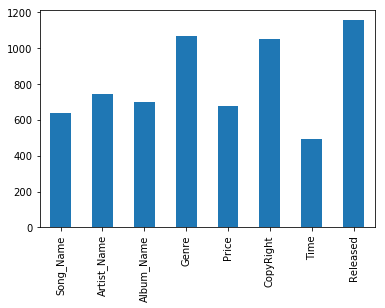

In [14]:
pos_variation_df = pd.DataFrame(data= pos_ri_norms_hybrid,columns=attributes)
pos_variation_df.sum().plot.bar()

In [13]:
pos_variation_df.to_csv('experiments/results/positives_ri_hybrid.csv',index=False)

## Nearest neighbors hybrid

In [ ]:
positives_nn_hybrid = calculate_nearest_neighbors_onAttributes(pos_classifier_hybrid,pos_ids,pos_ri_hybrid,
                                                       neg_classifier_hybrid,neg_ids,attributes,
                                                               attribute_len_hybrid)

In [17]:
negatives_nn_hybrid = calculate_nearest_neighbors_onAttributes(neg_classifier_hybrid,neg_ids,negatives_ri_hybrid,
                                                        pos_classifier_hybrid,pos_ids,
                                                        attributes,attribute_len_hybrid)

100%|██████████| 128/128 [00:00<00:00, 390.86it/s]


In [19]:
positives_nn_hybrid.to_csv('experiments/results/positives_nn_hybrid.csv',index=False)
negatives_nn_hybrid.to_csv('experiments/results/negatives_nn_hybrid.csv',index=False)

## Rnn model Evaluation

In [ ]:
rnn_model = dm.MatchingModel(attr_summarizer='rnn')
rnn_model.load_state('../../models/itunes_amazon_rnn.pth')

### Dataset creation

In [ ]:
neg_classifier_inputs_rnn,neg_ids_rnn = return_layer_input('../../Structured/itunes-amazon'
                                                                         ,'negatives',128,rnn_model,
                                                                        rnn_model.classifier,device=-1)

In [ ]:
pos_classifier_inputs_rnn,pos_ids_rnn = return_layer_input('../../Structured/itunes-amazon/',
                                                                       'positives',128,rnn_model,
                                                                       rnn_model.classifier,device=-1)

In [ ]:
rnn_model = rnn_model.cuda()

### Negative analysis

In [ ]:
classifier_length = len(neg_classifier_inputs_rnn[0][0])
attribute_len = int(classifier_length/len(attributes))

In [ ]:
negatives_ri_rnn,neg_ri_norms_rnn = computeRi(rnn_model.classifier,
                                                    attributes,neg_classifier_inputs_rnn,attribute_len,1)

In [ ]:
neg_variation_df = pd.DataFrame(data= neg_ri_norms_rnn,columns=attributes)
neg_variation_df.sum().plot.bar()

In [ ]:
neg_variation_df.to_csv('experiments-results/negatives_ri_rnn.csv',index=False)

### Positives analysis

In [ ]:
pos_ri_rnn,pos_ri_norms_rnn = computeRi(rnn_model.classifier,
                                                    attributes,pos_classifier_inputs_rnn,attribute_len,0)

In [ ]:
pos_variation_df = pd.DataFrame(data= pos_ri_norms_rnn,columns=attributes)
pos_variation_df.sum().plot.bar()

In [ ]:
pos_variation_df.to_csv('experiments-results/exp3/positives_ri_rnn.csv',index=False)

## Finding closer vectors

In [ ]:
from utils.distance_measures import calculate_nearest_neighbors_onAttributes

In [ ]:
positives_nn = calculate_nearest_neighbors_onAttributes(pos_classifier_inputs_rnn,pos_ids_rnn,pos_ri_rnn,
                                                       neg_classifier_inputs_rnn,neg_ids_rnn,attributes,attribute_len)

In [ ]:
negatives_nn = calculate_nearest_neighbors_onAttributes(neg_classifier_inputs_rnn,neg_ids_rnn,negatives_ri_rnn,
                                                        pos_classifier_inputs_rnn,pos_ids_rnn,
                                                        attributes,attribute_len)

In [ ]:
positives_nn.to_csv('experiments-results/positives_nn_rnn.csv',index=False)
negatives_nn.to_csv('experiments-results/exp3/negatives_nn_rnn.csv',index=False)

## Test bias on Rnn model

In [ ]:
## per ora solo per positivi
def testBiasPositives(model,testset_path,attribute,true_label,new_tokens):
    standard_test = dm.data.process_unlabeled(testset_path,model,ignore_columns=['id','label'])
    standard_pred = model.run_prediction(standard_test)
    if true_label == 1:
        true_positives = standard_pred[standard_pred.match_score>0.5].shape[0]
    else:
        true_positives = standard_pred[standard_pred.match_score<=0.5].shape[0]
    test_dm = pd.read_csv(testset_path)
    test_dm['ltable_'+attribute] = new_tokens[0]
    test_dm['rtable_'+attribute] = new_tokens[1]
    test_dm.to_csv('temp/new_test.csv',index=False)
    new_test = dm.data.process_unlabeled('temp/new_test.csv',model,ignore_columns=['id','label'])
    new_pred = model.run_prediction(new_test)
    if true_label ==1:
        new_true_pos = new_pred[new_pred.match_score >0.5].shape[0]
    else:
        new_true_pos = new_pred[new_pred.match_score <= 0.5].shape[0]
    return true_positives,new_true_pos

In [ ]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state('../../models/itunesamazon_hybrid.pth')

In [ ]:
testBiasPositives(hybrid_model,'../../Structured/itunes-amazon/test_positives.csv','Price',1,('sorrita','mammita'))